In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import math

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import seaborn as sns
import warnings

from sklearn.utils.extmath import cartesian
from collections import defaultdict
from itertools import product

warnings.filterwarnings('ignore')

np.random.seed(2017)

%run ../src/santa_helper.py

## Stochastic Optimization
Recently I stumbled upon this challenge on [https://www.kaggle.com/c/santas-uncertain-bags](Kaggle) which asked to solve this complex combinatorical problem but with a twist ( Hint: It involves randomness). So I decided to take this opportunity to brush up on my math skills. In the following post I will try to document my whole thought process.

### Problem Description

Problem Statement:

There are 9 different types of gifts, and total of 1000 bags. Each bag can hold only 50 pounds. Each gift has a fixed weight but individual weights are unknown. The weights for each of the gifts can be different. We only have information about the probability distributions for each type of gift.


Constraints:

1. A bag can not hold more than 50 pounds.
2. No gift can be used more than once.
3. Every bag must have 3 or more gifts.

Problem asks us to find out a combination of gifts in bags such that we are able to carry maximum amount of weight possible.

e.g.

```
Bag 1: horse_0 book_345 gloves_48 
Bag 2: doll_873 train_714 coal23 bike_85
...
```

### Nature of problem

- Optimization Problem ( Stochastic )
- Randomness in the data.
- Difficult to find the global minimum or maximum.
- Turn towards stochastic algorithms.

### Types of Stochastic Algorithms
>. . . are all alike in their promises.
> It is only in their deeds that they differ . - Moliere, The Miser

** There is a plethora of algorithms, but remember as problem change you have to change algorithm. **

- Random Search
- Genetic Algorithms
- Hill Climbing
- Simulated Annealing

and many more.

_Random Search_ - Provides a baseline with which we could compare other stochastic algorithms
_Genetic Algorithms_ - Probabilistic algorithm which yield candidates that could serve as potential solutions.

> The reasonable man adapts
himself to the world;
the unreasonable one persists
in trying to adapt the world to himself.
Therefore all progress depends
on the unreasonable man.

George Bernard Shaw, Maxims for Revolutionists

Sometimes you have to make unreasonable choices to make the problem tractable.

** Problem Representation **

How would we want to represent the problem ?

- Instead of trying to solve for all 1000 bags at once, try to solve for a much simpler case like for a single bag.
- So solution would look something like this, we would generate bags that have weight close enough to 50 and generate many such bags and then choose 1000 of them to get the highest possible score.

We are planning to solve more tractable version of this problem which involves a single bag that needs to be filled such that maximum possible weight can be carried.

Hard Constraints:

* Total weight of the bag must be less than 50.
* Atleast 3 items must be included in the bag.
* Total count of items must not exceed their total available count.

Consider solution vector to be something like:

```
solution : [c1, c2, c3, c4, c5, c6, c7, c8, c9]
example  : [8, 2, 3, 1, 0, 0, 1, 2, 1] represents 8 items from type1, 2 items from type2 and so on. 

```

Since each bit in the vector can take values up to maximum possible items for a type it means that solution space is:

$$max\_items\_type\_1 * max\_items\_type\_2 * max\_items\_type\_3 ...$$

in our case it turns out to be: $$1000 * 1100 * 500 * 1000 * 1200 * 1000 * 1000 * 200 * 166 = 21912000000000000000000000$$ possibilites which is huge.

We need to be search the space in much more efficient way.

We can make use of the fact that this is a constrained problem and only those candidates should be considered which actually would satisfy the hard constraints mentioned earlier.

So no need to generate solutions which are most likely to go take the total weight beyond 50 and no need to generate solutions where total number of items in the bag is less than 3.

### Solution

- Candidate solution generation ( Genetic Algorithm )
- Bag Packing ( Linear Programming )

In [2]:
def sample_horse(size=1):
    return np.maximum(0, np.random.normal(5,2,size))

def sample_ball(size=1):
    return np.maximum(0, 1 + np.random.normal(1,0.3,size))

def sample_bike(size=1):
    return np.maximum(0, np.random.normal(20,10,size))

def sample_train(size=1):
    return np.maximum(0, np.random.normal(10,5,size))

def sample_coal(size=1):
    return 47 * np.random.beta(0.5,0.5,size)

def sample_book(size=1):
    return np.random.chisquare(2,size)

def sample_doll(size=1):
    return np.random.gamma(5,1,size)

def sample_block(size=1):
    return np.random.triangular(5,10,20,size)

def sample_gloves(size=1):
    dist1 = 3.0 + np.random.rand(size)
    dist2 = np.random.rand(size)
    toggle = np.random.rand(size) < 0.3
    dist2[toggle] = dist1[toggle]
    return dist2

samplers = {
    "horse": sample_horse,
    "ball": sample_ball,
    "bike": sample_bike,
    "train": sample_train,
    "coal": sample_coal,
    "book": sample_book,
    "doll": sample_doll,
    "blocks": sample_block,
    "gloves": sample_gloves
}

def sample(gift_type, quantity=1, size=1):
    """
    Use the sampling method for a gift type to generate samples
    from the underlying distribution.
    
    Also takes quantity and size as the parameters which represent
    how many iterations should we consider and what should be the sample size for each of
    the iteration.
    """
    return np.sum(samplers[gift_type](quantity * size).reshape(quantity, size), axis=0)

print('Estimation of weight of bag containing two horses: \n{}'.format(sample('horse', 2, 10)))

Estimation of weight of bag containing two horses: 
[  4.82637366   7.80104358   7.53720465  12.97055717   9.63975113
   8.05202214   8.11415732   7.4164609    8.10915182   6.12412129]


** Now we need to generate enough samples to have any sort of confidence regarding the estimated weight.**

In [3]:
def bag_name(bag):
    return str(list(map(lambda gift: "{}({})".format(gift, bag[gift]), sorted(bag.keys()))))

def create_bag_weight_sampler(bag):
    def bag_weight_sampler(size=1):
        weight = np.array([0.0]*size)
        for gift in sorted(bag.keys()):
            weight += sample(gift, bag[gift], size)
        return weight
    return bag_weight_sampler, bag_name(bag)

bag = { "horse": 1, "ball": 2 } # this defines that bag contains 1 horse and 2 balls
bag_weight_sampler, name = create_bag_weight_sampler(bag)
print("Weight estimations for this bag {}: {}".format(name, bag_weight_sampler(10)))

Weight estimations for this bag ['ball(2)', 'horse(1)']: [ 11.07989868   9.0213798    6.85237687   8.19870475   4.59779781
   9.15103981   6.0782703    7.41647187   9.25937581  10.54216101]


>If we can really understand the problem,
the answer will come out of it ,
because the answer is not separate
from the problem.

Krishnamurti

We cannot expect to find a solution to a problem unless we have fair sense of what it ask of us ?

['book(1)', 'horse(2)']: mean=12.018761434887095 | std=3.5102605113772345
['ball(2)', 'horse(1)']: mean=9.012789506289119 | std=2.0126845467460552
['ball(1)']: mean=2.00202528020715 | std=0.3001094540729906
['bike(1)']: mean=20.217204900956204 | std=9.780419611692931
['train(1)']: mean=10.025292525807563 | std=4.895800470297536
['coal(1)']: mean=23.323512994574067 | std=16.629852653604985
['book(1)']: mean=1.9999589731772547 | std=1.9759229938903402
['doll(1)']: mean=4.988727895119982 | std=2.2188089549268466
['blocks(1)']: mean=11.677478388311739 | std=3.132245130041533
['gloves(1)']: mean=1.40651167977616 | std=1.4075395121365537
['bike(1)', 'coal(1)']: mean=43.7637325173457 | std=19.145095363064595
['horse(2)', 'train(1)']: mean=20.116829758726492 | std=5.623154119073732


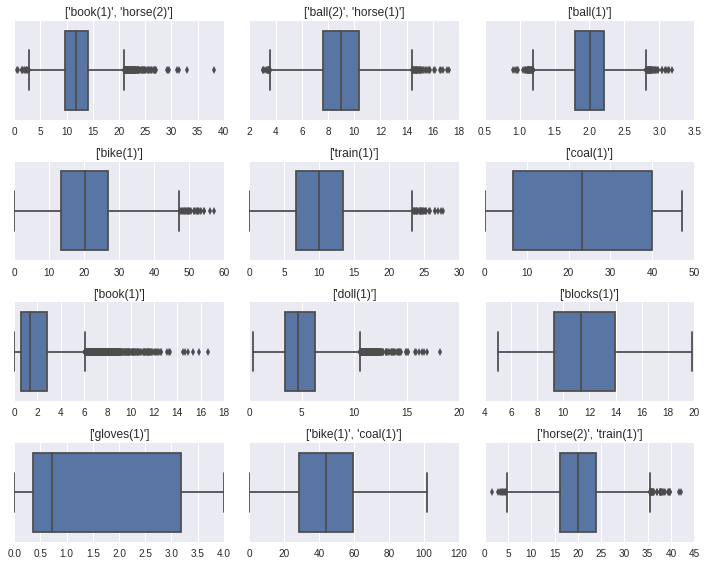

In [4]:
def plot_bag_weight_distributions(bags, size=10000):
    plot_distributions(bags, create_bag_weight_sampler, size=size)

def plot_distributions(bags, sampler_builder, size=10000, fit=None):
    num_plots = len(bags)
    num_cols = int(round(math.sqrt(num_plots)))
    num_rows = (num_plots // num_cols)
    num_rows = num_rows if num_plots % num_cols == 0 else num_rows + 1
    
    f, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))
    axes = axes.reshape(-1)
    for i in range(num_plots):
        current_bag = bags[i]
        current_bag_sampler, current_bag_name = sampler_builder(current_bag)
        current_sample = current_bag_sampler(size)
        print("{}: mean={} | std={}".format(current_bag_name, np.mean(current_sample), np.std(current_sample)))
        current_axis = axes[i]
#         sns.distplot(current_sample, ax=current_axis, fit=fit, kde=False)
        # plot a boxplot
        sns.boxplot(x=current_sample, ax=current_axis)
        current_axis.set_title(current_bag_name)
        current_axis.set_yticklabels([])
    plt.tight_layout()
    plt.show()
    
single_gift_bags = [
    {"horse": 2, "book": 1},
    {"ball": 2, "horse": 1},
    {"ball": 1},
    {"bike": 1},
    {"train": 1},
    {"coal": 1},
    {"book": 1},
    {"doll": 1},
    {"blocks": 1},
    {"gloves": 1},
    {'bike':1, 'coal':1},
    {'horse':2, 'train': 1}
]

plot_bag_weight_distributions(single_gift_bags)

** Now we have a fair indication about mean weight and standard deviation in weights of different items. **

### Evaluation Function

Now we need to set up a function which could give us some kind of feedback regarding a potential solutoion.

In [5]:
def evaluate_bag(bag, n_samples=10000):
    """
    Estimates the weight of a bag with a certain configuration
    It would any samples where total weight went beyond 50 to 0,
    so that those bags would be penalized eventually.
    
    Optimization: Instead of generate all samples, generate n_samples / 1000
    and see if the samples show low variance then stop otherwise continue for
    whole number of samples initially asked for.
    """
    
    batch_samples = int(n_samples / 1000)
    
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(batch_samples)
    bag_weight_samples[bag_weight_samples > 50] = 0
    
    mean_weight_bag = np.mean(bag_weight_samples)
    std_weight_bag  = np.std(bag_weight_samples)
    
    if mean_weight_bag > 28. and std_weight_bag < 7.:
        # pretty sure about the estimated result
        return mean_weight_bag
    elif mean_weight_bag > 20. and std_weight_bag > 7.:
        # not very sure about the result may need more iterations
        remaining_samples = n_samples - batch_samples
        bag_weight_samples = bag_weight_sampler(remaining_samples)
        bag_weight_samples[bag_weight_samples > 50] = 0
    
        mean_weight_bag = np.mean(bag_weight_samples)
        
        return mean_weight_bag
    else:
        # no chance
        return mean_weight_bag

### Genertic Algorithms

These are probabilistic algorithm that use techniques from evolutionary biology to create candidates that could lead us to potential solution.

Terminology:

- Individual - Candidate solution
- Population - Group of individuals
- Fitness    - Determines the fitness of the individual, lower is better ( closer to goal )
- Mutation, Crossover - Biologically inspired operators.

In [5]:
def individual(max_item_possible):
    'Create a member of the population.'
    length = len(max_item_possible)
    
    return np.array([np.random.randint(0, member + 1) for member in max_item_possible])

def population(count, max_item_possible):
    """
    Create a number of individuals ( i.e population)
    """
    
    return np.array([individual(max_item_possible) for i in range(count)])

def fitness(individual, weight_constraint):
    """
    Determines the fitness of the individual, lower is better.
    """
    
    estimated_weight = evaluate_bag(individual)
    return weight_constraint - estimated_weight

def grade(pop, weight_constraint):
    'Find average fitness for a population.'
    summed = reduce(add, (fitness(x, weight_constraint) for x in pop), 0)
    return summed / len(pop)

def mutate(population, max_item_possible, chance_to_mutate=0.01):
    for individual in population:
        if chance_to_mutate > np.random.random():
            index_to_modify = np.random.randint(0, len(individual))
            individual[index_to_modify] = np.random.randint(0, \
                                                            max_item_possible[index_to_modify] + 1)
        
    return population

** Evolution takes in a population and the goal and then generate individuals that would be part of the next generation, we can specify how many individuals we want to retain from previous generation and degree of mutation. **

In [6]:
def evaluate_bag(bag, n_samples=1000):
    """
    Estimates the weight of a bag with a certain configuration
    It would any samples where total weight went beyond 50 to 0,
    so that those bags would be penalized eventually.
    """
    
    bag_weight_sampler = create_bag_weight_sampler(bag)
    bag_weight_samples = bag_weight_sampler(n_samples)
    bag_weight_samples[bag_weight_samples > 50] = 0
    
    return np.mean(bag_weight_samples)

In [7]:
def evolve(pop, weight_constraint, max_item_possible, retain=0.2, random_select=0.05, mutate=0.01):
    graded = [ (fitness(x, weight_constraint), x) for x in pop]
    
    graded = [ x[1] for x in sorted(graded)]
    retain_length = int(len(graded)*retain)
    parents = graded[:retain_length]

    # randomly add other individuals to promote genetic diversity
    for individual in graded[retain_length:]:
        if random_select > np.random.random():
            parents.append(individual)

    # mutate some individuals
    for individual in parents:
        if mutate > np.random.random():
            pos_to_mutate = np.random.randint(0, len(individual)-1)
            # this mutation is not ideal, because it
            # restricts the range of possible values,
            # but the function is unaware of the min/max
            # values used to create the individuals,
            individual[pos_to_mutate] = np.random.randint(0, max_item_possible[pos_to_mutate] + 1)

    # crossover parents to create children
    parents_length = len(parents)
    desired_length = len(pop) - parents_length
    children = []
    
    parents  = list(parents) # convert numpy array to list
    
    while len(children) < desired_length:
        male = np.random.randint(0, parents_length-1)
        female = np.random.randint(0, parents_length-1)
        
        if male != female:
            male_individual = list(parents[male])
            female_individual = list(parents[female])
        
            half = int(len(male_individual) / 2)
            child = male_individual[:half] + female_individual[half:]
            children.append(child)

#     parents.extend(children)
    return np.array(parents) # convert it back to numpy array

In [17]:
max_item_possible = [26, 3, 5, 25, 3, 10, 36, 11, 5]
weight_constraint = 50
modified_max_item_possible = list(map(np.floor, np.array(max_item_possible) / 5.))
pop = population(100, modified_max_item_possible)
mutated_population = mutate(pop.copy(), modified_max_item_possible)
evolved_pop = evolve(pop.copy(), weight_constraint, \
                     modified_max_item_possible, retain=0.3,\
                     random_select=0.01, mutate=0.01)

** Let's try to plot the estimated weights of the bags generated so far from this problem. **

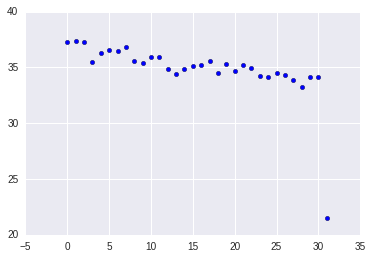

In [18]:
perf = np.array(list(map(evaluate_bag, evolved_pop)))
plt.scatter(np.arange(0, len(evolved_pop)), perf);

** As we can see we are able to generate bags that have weights close to 35 most of the time.  Now we are able to create candidate solutions, now it is time to choose 1000 bags out of all possible solutions.**

### Linear Programming

```
Linear programming (LP) (also called linear optimization) is a method to achieve the best outcome (such as maximum profit or lowest cost) in a mathematical model whose requirements are represented by linear relationships. Linear programming is a special case of mathematical programming (mathematical optimization).

Linear programs are problems that can be expressed in canonical form as
```


<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/f5abfafd1199e99a37e01b9ce9ef49c5405ea72a'>

In short we will try to choose 1000 bags out all possible bags such that all the hard constraints mentioned are satisfied and we are able to carry maximum possible weight. Here is the code that would solve this for you.

In [19]:
def pack_linprog(bags, distributions, min_variance, max_bags=1000):
    # objective: c.T * x -> min
    c = - distributions[:,0] # optimize sum of expected bag utilities
    
    # constraint: A_ub * x <= b_ub
    A_ub = bags.T # don't use more gifts than available
    b_ub = np.array([num_gifts_available[gift] for gift in gift_types])
    
    A_ub = np.vstack([A_ub, np.ones(A_ub.shape[1])]) # pack at most max_bags gifts
    b_ub = np.hstack([b_ub, [max_bags]])
    
    if min_variance is not None:
        A_ub = np.vstack([A_ub, -distributions[:,1]]) # require minimum variance
        b_ub = np.hstack([b_ub, [-min_variance]])
    
    result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub)
    if result["success"] == False:
        return [], True
    else:
        return result["x"].astype('int64'), False


def pack_bags(bags, distributions, min_variance=None):
    max_bags = 1000
    bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance)
    while np.sum(bag_quantities) < 1000:
        max_bags += 1
        bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance, max_bags=max_bags)
        if max_bags > 1015:
            print("WARNING: not getting 1000 bags")
            break
        if infeasible:
            continue
    
    if infeasible:
        print("infeasible")
        return [], [], []
    
    chosen_bag_idx = np.where(bag_quantities)[0]
    chosen_bags = bags[chosen_bag_idx]
    chosen_distributions = distributions[chosen_bag_idx]
    chosen_quantities = bag_quantities[chosen_bag_idx]
    
    while np.sum(chosen_quantities) > 1000:
        idx = np.random.randint(len(chosen_quantities))
        chosen_quantities[idx] = max (chosen_quantities[idx]-1, 0)
    
    score_distribution = np.dot(chosen_quantities, chosen_distributions)
    print("{} bags - score distribution: mean = {:.2f} | var = {:.2f}"
          .format(np.sum(chosen_quantities), score_distribution[0], score_distribution[1]))
    
    return chosen_bags, chosen_distributions, chosen_quantities

** In ideal settings if you are able to generate bags which have an exact weight of 50 and then are able to fit 1000 bags, then maximum possible score you would get is 50,000. But there is one twist in this problem, each item has exact weight which we have no clue but our submission will be judged based on that score, so not only we will have to create bags that look well in the worst case, but need to somehow find out information about exact weights from the score that we get when we make a submission to the system, we can not make more than 3 submissions per day. So we will have to be clever enough to do it. Currently I am sitting at 204th position out of 704 competitors that took part in the competition with 3 more days to go. Wish me luck. **